In [15]:
import numpy as np
import pandas as pd

import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import DataLoader, TensorDataset

from src.model_implementations import split_by_labels, Double_Net
from src.implementations import *

In [16]:
labeled_data = pd.read_csv('labeled_data.csv')

# <u><b> Prediction Models: </b></u>

In [17]:
N_SPLIT = 5
KSPLIT = N_SPLIT - 1

In [18]:
GAGPOL_data = labeled_data[labeled_data['Target Name'] == 'Gag-Pol polyprotein [489-587]']

In [19]:
train, test = split_by_labels(labeled_data,N_SPLIT)
y_train, y_test = np.array(train['Ki (nM)'], dtype=np.float64()).reshape(-1, 1), np.array(test['Ki (nM)'], dtype=np.float64()).reshape(-1, 1)
X_train, X_test = train.drop(columns=['Ki (nM)','Ligand SMILES','Labels', 'Target Name'], axis=1), test.drop(columns=['Ki (nM)','Ligand SMILES','Labels', 'Target Name'], axis=1)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train_scaled, y_test_scaled = np.log10(y_train), np.log10(y_test)

c:\Users\hudrya\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [20]:
lm = Ridge(random_state=42)

gridsearch_lm = GridSearchCV(estimator=lm, param_grid={'alpha':np.logspace(-4,0,20)}, scoring='neg_mean_squared_error', cv=KSPLIT) # no shuffling so ok

gridsearch_lm.fit(X_train, y_train_scaled)
pred = gridsearch_lm.predict(X_test)
pred_LM = pow(10,pred)

array([158])

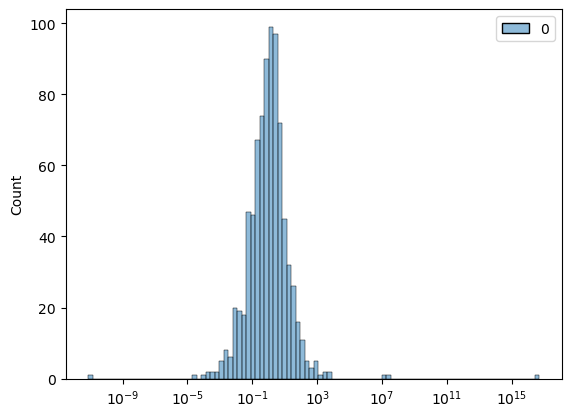

In [29]:
error_LM = pred_LM/y_test
sns.histplot(error_LM,bins=100,log_scale=True);
sum((np.log10(error_LM) < np.log10(1.5)) & (np.log10(error_LM) > np.log10(0.5)))

In [22]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10,random_state=42)

gridsearch_rf = GridSearchCV(estimator=rf, param_grid={'max_depth': [10]}, scoring='neg_mean_squared_error')

rf.fit(X_train, y_train_scaled.ravel())
pred = rf.predict(X_test)
pred_RF = pow(10,pred)

205

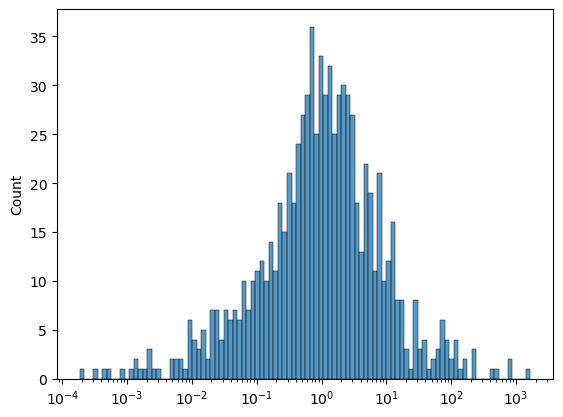

In [23]:
error_RF = pred_RF/y_test.ravel()
sns.histplot(error_RF,bins=100,log_scale=True)
sum((np.log10(error_RF) < np.log10(1.5)) & (np.log10(error_RF) > np.log10(0.5)))

In [24]:
XGBoost = GradientBoostingRegressor(n_estimators=100, max_depth=10, random_state=42)

gridsearch_XGBoost = GridSearchCV(estimator=XGBoost, param_grid={'max_depth': np.arange(1,10)}, scoring='mean_squared_error', cv=KSPLIT)

XGBoost.fit(X_train, y_train_scaled.ravel())
pred = XGBoost.predict(X_test)
pred_XGB = pow(10,pred)

257

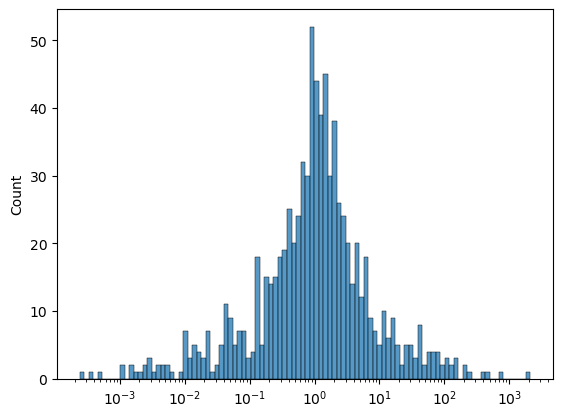

In [25]:
error_XGB = pred_XGB/y_test.ravel()
sns.histplot(error_XGB,bins=100,log_scale=True)
sum((np.log10(error_XGB) < np.log10(1.5)) & (np.log10(error_XGB) > np.log10(0.5)))

In [26]:
num_epochs = 30

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)

dataset = TensorDataset(X_train_t, y_train_t)
dataloader = DataLoader(dataset, batch_size=300, shuffle=False)

DN = Double_Net(input_size=X_train.shape[1], K=4096, dropout_rate=0.0)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DN.parameters(), lr=10e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(dataloader):

        optimizer.zero_grad()
        output = DN(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    scheduler.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/30, Loss: 3.2817
Epoch 2/30, Loss: 1.8647
Epoch 3/30, Loss: 0.6964
Epoch 4/30, Loss: 0.4449
Epoch 5/30, Loss: 0.5489
Epoch 6/30, Loss: 0.1959
Epoch 7/30, Loss: 0.1136
Epoch 8/30, Loss: 0.0692
Epoch 9/30, Loss: 0.1617
Epoch 10/30, Loss: 0.2080
Epoch 11/30, Loss: 0.5283
Epoch 12/30, Loss: 0.1361
Epoch 13/30, Loss: 0.0236
Epoch 14/30, Loss: 0.0235
Epoch 15/30, Loss: 0.0056
Epoch 16/30, Loss: 0.0032
Epoch 17/30, Loss: 0.0023
Epoch 18/30, Loss: 0.0013
Epoch 19/30, Loss: 0.0010
Epoch 20/30, Loss: 0.0008
Epoch 21/30, Loss: 0.0005
Epoch 22/30, Loss: 0.0005
Epoch 23/30, Loss: 0.0005
Epoch 24/30, Loss: 0.0005
Epoch 25/30, Loss: 0.0005
Epoch 26/30, Loss: 0.0005
Epoch 27/30, Loss: 0.0005
Epoch 28/30, Loss: 0.0005
Epoch 29/30, Loss: 0.0005
Epoch 30/30, Loss: 0.0005


In [27]:
DN.eval()
with torch.no_grad():
    pred = DN(X_test_t)
    pred_DN = pow(10,pred.detach().cpu().numpy())

array([210])

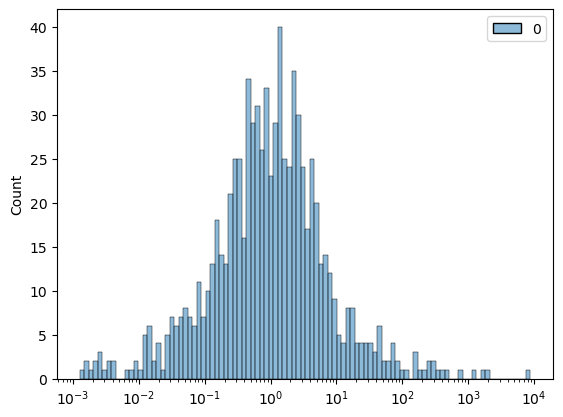

In [28]:
error_DN = pred_DN/y_test
sns.histplot(error_DN,bins=100,log_scale=True)
sum((np.log10(error_DN) < np.log10(1.5)) & (np.log10(error_DN) > np.log10(0.5)))